In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [29]:
data = pd.read_csv('/Users/macbook/py-restaurant-data-analysis/Data/base_new.csv')
print(data.head())

   quantity                 name  price             datetime
0         2        Plain Papadum   0.80  2019-08-03 20:25:00
1         1     King Prawn Balti  12.95  2019-08-03 20:25:00
2         1          Garlic Naan   2.95  2019-08-03 20:25:00
3         1        Mushroom Rice   3.95  2019-08-03 20:25:00
4         1  Paneer Tikka Masala   8.95  2019-08-03 20:25:00


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

name
Plain Papadum           10648
Pilau Rice               6367
Plain Naan               4983
Garlic Naan              3318
Plain Rice               2964
Onion Bhajee             2749
Mango Chutney            2504
Chicken Tikka Masala     2473
Chapati                  1935
Mint Sauce               1840
Name: quantity, dtype: int64


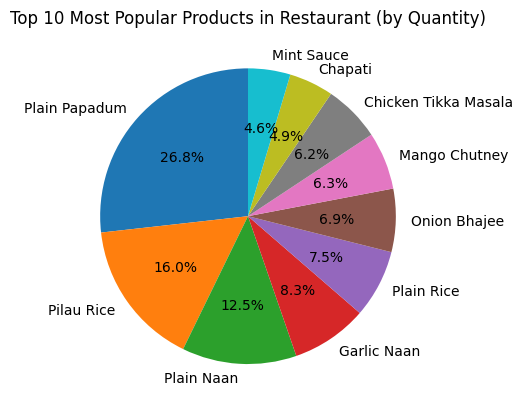

In [50]:
sorted_sum = data.groupby('name')['quantity'].sum().sort_values(ascending=False)
top_10 = sorted_sum.head(10)
print(top_10)
plt.title("Top 10 Most Popular Products in Restaurant (by Quantity)")

restaurant_names = top_10.index.tolist()
quantities = top_10.values.tolist()

plt.pie(quantities, labels=restaurant_names, autopct='%1.1f%%', startangle=90)
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

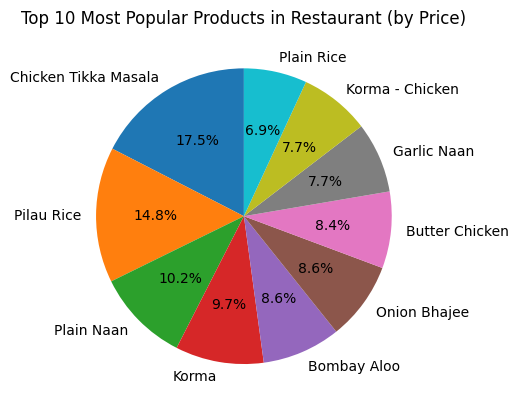

In [52]:
data['Item Price'] = data['price'] * data['quantity']

sorted_sum_pr = data.groupby('name')['Item Price'].sum().sort_values(ascending=False)
top_10 = sorted_sum_pr.head(10)

plt.title("Top 10 Most Popular Products in Restaurant (by Price)")

restaurant_names = top_10.index.tolist()
price = top_10.values.tolist()

plt.pie(price, labels=restaurant_names, autopct='%1.1f%%', startangle=90)
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

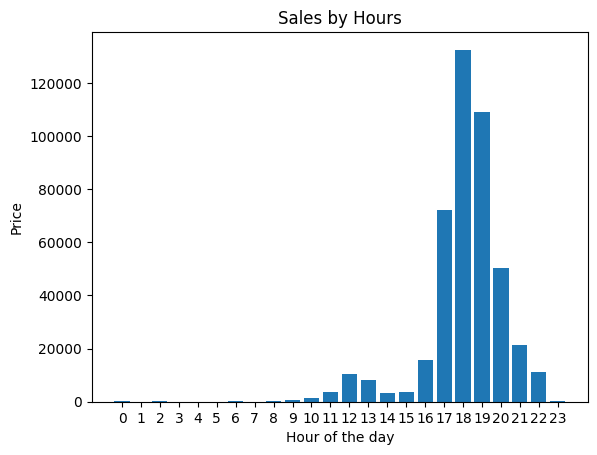

In [62]:
data["datetime"] = pd.to_datetime(data["datetime"])
data['time'] = data["datetime"].dt.hour
sorted_sum_pr = data.groupby('time')['Item Price'].sum()
hours = sorted_sum_pr.index.tolist()
price = sorted_sum_pr.values.tolist()
plt.title("Sales by Hours")
plt.bar(hours, price)
plt.xlabel("Hour of the day")
plt.ylabel("Price")
plt.xticks(range(24))
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

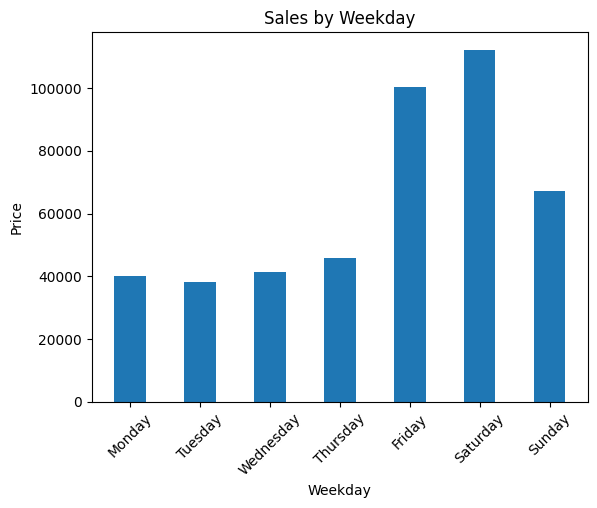

In [66]:
import calendar
data["datetime"] = pd.to_datetime(data["datetime"])
data['Weekday'] = data["datetime"].dt.dayofweek
sorted_sum_pr = data.groupby('Weekday')['Item Price'].sum()
weekday = sorted_sum_pr.index.tolist()
weekday_names = [calendar.day_name[i] for i in weekday]
price = sorted_sum_pr.values.tolist()
plt.title("Sales by Weekday")
plt.bar(weekday_names, price, width=0.45)
plt.xlabel("Weekday")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()